In [3]:
## Import
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# import OGGM modules
import oggm
from oggm import cfg, graphics, utils
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, massbalance, flowline, inversion

import sys
sys.path.append('../code/')
from utils import get_leclercq_length, rmsd_anomaly
from mb_calibration_grindel import mb_calib


def glen_a(factors, prcp_fac=None, ref_df=None, path=None):
    """ Run model with different values for the creep parameter A and compute
    correlation and rmsd to length reference. Returns findings as DataFrame,
    and stores to file if path is given.

    :param path:
    :return:
    """

    ## Initialize
    # load default parameter file
    cfg.initialize()
    # specify working directory
    wdir = '/Users/oberrauch/work/grindelwald/working_directories/working_example/'
    cfg.PATHS['working_dir'] = wdir

    # set border high enough for idealized experiment
    cfg.PARAMS['border'] = 250

    # using intersects
    cfg.PARAMS['use_intersects'] = True

    # set climate/massbalance hyper parameters for HistAlp dataset
    cfg.PARAMS['baseline_climate'] = 'HISTALP'
    if prcp_fac:
        cfg.PARAMS['prcp_scaling_factor'] = prcp_fac
    else:
        cfg.PARAMS['prcp_scaling_factor'] = 1.75
    cfg.PARAMS['temp_melt'] = -1.75

    ## Preprocessing
    # get RGI entity
    rgi_id = 'RGI60-11.01270'
    rgi_df = get_rgi_glacier_entities([rgi_id], version='6')
    rgi_entity = rgi_df.iloc[0]
    rgi_df.plot()

    # specify intersects
    cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

    # prepare glacier directory
    gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

    # ### GIS
    gis.define_glacier_region(gdir, entity=rgi_entity)
    gis.glacier_masks(gdir)

    # ### Centerlines
    centerlines.compute_centerlines(gdir)
    centerlines.initialize_flowlines(gdir)
    centerlines.compute_downstream_line(gdir)
    centerlines.compute_downstream_bedshape(gdir)
    centerlines.catchment_area(gdir)
    centerlines.catchment_intersections(gdir)
    centerlines.catchment_width_geom(gdir)
    centerlines.catchment_width_correction(gdir)

    ## Climate and mass balance parameters
    # process the HistAlp climate file
    climate.process_histalp_data(gdir)
    climate.local_t_star(gdir, ref_df=ref_df)
    climate.mu_star_calibration(gdir)

    ## Mass balance
    # instance mass balance model using the historic climate file
    mb_model = massbalance.PastMassBalance(gdir)

    # store default values for Glen's A parameter
    inv_glen_a = cfg.PARAMS['inversion_glen_a']
    glen_a = cfg.PARAMS['glen_a']

    # create DataFrame
    df = pd.DataFrame(index=factors, columns=['correlation', 'rmsd', 'amp_diff', 'xcorr', 'xcorr_shift'])

    for f in factors:
        # Change the creep parameter
        cfg.PARAMS['inversion_glen_a'] = inv_glen_a * f
        cfg.PARAMS['glen_a'] = glen_a * f

        ## Inversion
        # run ice thicknes inversion
        inversion.prepare_for_inversion(gdir)
        inversion.mass_conservation_inversion(gdir)
        inversion.filter_inversion_output(gdir)

        ## Dynamic model
        # finalize the preprocessing
        flowline.init_present_time_glacier(gdir)

        ## Model
        # read needed file
        ci = gdir.read_pickle('climate_info')
        fls = gdir.read_pickle('model_flowlines')

        # now we can use the flowline model
        model = flowline.FluxBasedModel(fls, mb_model=mb_model,
                                        y0=ci['baseline_hydro_yr_0'])

        # run model over entire HistAlp period
        run_ds, diag_ds = model.run_until_and_store(2014)

        # get modeled length changes as DataFrame
        length_mod = diag_ds.length_m.to_dataframe()[['hydro_year', 'length_m']]
        length_mod = length_mod.reindex(index=length_mod.hydro_year)
        length_mod.drop('hydro_year', axis=1, inplace=True)
        length_mod.columns = ['model']

        # get reference length (Leclercq)
        length_ref = get_leclercq_length('11.01270')

        # combine both records
        length_df = pd.concat([length_ref, length_mod], axis=1)

        # get control data
        control = length_df.loc[1894:]
        # compute correlation coefficient
        corr = control.corr().iloc[0, 1]
        # compute rmsd anomaly
        rmsd = rmsd_anomaly(control.ref, control.model)

        # compute amplitude
        amp = control.max() - control.min()
        amp_diff = amp.diff().iloc[-1]

        # compute cross correlation
        shift = np.arange(-15, 15, 1)
        xcorr = list()
        for s in shift:
            ref = control.ref.shift(s)
            mod = control.model
            df_ = pd.concat([ref, mod], axis=1).dropna()
            xcorr.append(df_.corr().iloc[0, 1])

        xcorr = pd.Series(xcorr, index=shift)
        xcorr_shift = xcorr.idxmax()
        xcorr = xcorr.max()

        df.loc[f] = [corr, rmsd, amp_diff, xcorr, xcorr_shift]

    if path:
        df.to_csv(path)

    # reset the creep parameter to default values
    cfg.PARAMS['inversion_glen_a'] = inv_glen_a
    cfg.PARAMS['glen_a'] = glen_a

    return df


def cross_correlation_with_mb_calibration():
    """

    :return:
    """
    # iterate over different precipitation factors
    prcp_factors = np.linspace(1, 1.75, 16)
    for prcp_fac in prcp_factors:
        # check if mb calibration already produced correct t* file
        fn = '{:.2f}'.format((prcp_fac)).replace('.', '_')
        fn = '/Users/oberrauch/work/grindelwald/ref_tstars/ref_tstars_prcp_{}.csv'.format(fn)
        if os.path.isfile(fn):
            # read prepared t* reference list
            ref_df = pd.read_csv(fn, index_col=0)
        else:
            # run mass balance calibration
            mb_calib(prcp_fac)
            # read t* reference list
            ref_df = pd.read_csv('/Users/oberrauch/oggm-fork/oggm/grindel/mb_calib_wd/ref_tstars.csv')
        # define factors scaling the creep parameters
        factors = np.concatenate((np.linspace(0.1, 1, 9, endpoint=False),
                                  np.linspace(1, 20, 20)))
        # compute length correlation for different A parameters
        fp = 'length_corr/length_corr_prcp_fac_{:.2f}.csv'.format(prcp_fac)
        glen_a(factors, prcp_fac=prcp_fac, ref_df=ref_df, path=fp)


def cross_correlation_without_mb_calibration():
    """

    :return:
    """
    # iterate over different precipitation factors
    prcp_factors = np.linspace(1, 1.75, 16)
    for prcp_fac in prcp_factors:
        # define factors scaling the creep parameters
        factors = np.concatenate((np.linspace(0.1, 1, 9, endpoint=False),
                                  np.linspace(1, 20, 20)))
        # read reference t* list
        fn = get_demo_file('oggm_ref_tstars_rgi6_histalp.csv')
        ref_df = ref_df = pd.read_csv(fn, index_col=1)
        # compute length correlation for different A parameters
        fp = '../data/length_corr_no_mb_calib/length_corr_prcp_fac_{:.2f}.csv'.format(prcp_fac)
        glen_a(factors, prcp_fac=prcp_fac, path=fp, ref_df=ref_df)

In [7]:
fn = get_demo_file('oggm_ref_tstars_rgi6_histalp.csv')
ref_df = ref_df = pd.read_csv(fn, index_col=0)

# Scratch notebook to test some ideas

In [1]:
import xml.etree.ElementTree as ET
tree = ET.parse('/Users/oberrauch/Desktop/gpr_grindel 2.xml')
root = tree.getroot()

In [17]:
a = child.attrib['id']

'path4570'

In [26]:
# create containers
points = dict()
for child in root:
    if child.attrib['id'][:4] == 'path':
        points[child.attrib['id']] = child.attrib['d']

In [27]:
points

{'path4570': 'm 0.54618849,145.29194 61.65965251,17.77097 5.33343,0.12878 4.422845,-0.25755 4.552928,0.64387 5.463513,0.64388 4.683011,0.77265 4.422845,-0.12877 5.333431,0.90142 4.552926,-0.5151 4.81309,0.5151 h 5.07327 4.81309 4.0326 l 5.98384,0.64388 4.0326,0.25755 5.46351,0.38632 5.07326,-0.5151 c 0,0 3.51226,0.25755 4.0326,0.5151 0.52033,0.25755 4.81309,0.77266 4.81309,0.77266 l 5.07327,1.0302 4.94317,-0.25755 h 4.42285 l 4.8131,0.38632 5.07326,1.15898 5.33342,1.15897 4.0326,-0.25755 4.94318,0.38633 5.07326,-0.12878 4.29276,0.12878 4.55293,-0.38633 h 5.5936 l 4.55293,-0.12877 4.29276,-0.12878 5.33343,0.38633 3.64233,-0.25755 6.11394,0.5151 4.0326,-0.77265 5.20334,-0.12878 5.46351,-0.5151 4.55293,-0.90142 4.94318,-0.64388 4.68302,-0.77265 3.64233,-0.5151 5.07326,-0.25755 4.94319,-0.5151 5.46351,-0.5151 4.16268,-0.25755 5.33342,-0.5151 4.8131,-0.64388 4.16268,-0.77265 5.07326,-0.64388 4.42285,-0.38632 4.94317,-0.38633 4.94318,-0.64387 4.55293,-0.5151 5.20335,-0.77265 4.94318,-0.77266

In [28]:
points = 'm 0.54618849,145.29194 61.65965251,17.77097 5.33343,0.12878 4.422845,-0.25755 4.552928,0.64387 5.463513,0.64388 4.683011,0.77265 4.422845,-0.12877 5.333431,0.90142 4.552926,-0.5151 4.81309,0.5151 h 5.07327 4.81309 4.0326 l 5.98384,0.64388 4.0326,0.25755 5.46351,0.38632 5.07326,-0.5151 c 0,0 3.51226,0.25755 4.0326,0.5151 0.52033,0.25755 4.81309,0.77266 4.81309,0.77266 l 5.07327,1.0302 4.94317,-0.25755 h 4.42285 l 4.8131,0.38632 5.07326,1.15898 5.33342,1.15897 4.0326,-0.25755 4.94318,0.38633 5.07326,-0.12878 4.29276,0.12878 4.55293,-0.38633 h 5.5936 l 4.55293,-0.12877 4.29276,-0.12878 5.33343,0.38633 3.64233,-0.25755 6.11394,0.5151 4.0326,-0.77265 5.20334,-0.12878 5.46351,-0.5151 4.55293,-0.90142 4.94318,-0.64388 4.68302,-0.77265 3.64233,-0.5151 5.07326,-0.25755 4.94319,-0.5151 5.46351,-0.5151 4.16268,-0.25755 5.33342,-0.5151 4.8131,-0.64388 4.16268,-0.77265 5.07326,-0.64388 4.42285,-0.38632 4.94317,-0.38633 4.94318,-0.64387 4.55293,-0.5151 5.20335,-0.77265 4.94318,-0.77266 h 5.20334 l 4.16268,-0.77265 5.07326,-0.77265 4.94319,-1.0302 4.16267,-0.64388 4.81309,-0.12877 64.91174,-9.65814'
# 
points.split(' ')

['m',
 '0.54618849,145.29194',
 '61.65965251,17.77097',
 '5.33343,0.12878',
 '4.422845,-0.25755',
 '4.552928,0.64387',
 '5.463513,0.64388',
 '4.683011,0.77265',
 '4.422845,-0.12877',
 '5.333431,0.90142',
 '4.552926,-0.5151',
 '4.81309,0.5151',
 'h',
 '5.07327',
 '4.81309',
 '4.0326',
 'l',
 '5.98384,0.64388',
 '4.0326,0.25755',
 '5.46351,0.38632',
 '5.07326,-0.5151',
 'c',
 '0,0',
 '3.51226,0.25755',
 '4.0326,0.5151',
 '0.52033,0.25755',
 '4.81309,0.77266',
 '4.81309,0.77266',
 'l',
 '5.07327,1.0302',
 '4.94317,-0.25755',
 'h',
 '4.42285',
 'l',
 '4.8131,0.38632',
 '5.07326,1.15898',
 '5.33342,1.15897',
 '4.0326,-0.25755',
 '4.94318,0.38633',
 '5.07326,-0.12878',
 '4.29276,0.12878',
 '4.55293,-0.38633',
 'h',
 '5.5936',
 'l',
 '4.55293,-0.12877',
 '4.29276,-0.12878',
 '5.33343,0.38633',
 '3.64233,-0.25755',
 '6.11394,0.5151',
 '4.0326,-0.77265',
 '5.20334,-0.12878',
 '5.46351,-0.5151',
 '4.55293,-0.90142',
 '4.94318,-0.64388',
 '4.68302,-0.77265',
 '3.64233,-0.5151',
 '5.07326,-0.25755

In [72]:
tmp = '0,296.99999 5.2916667,281.12498 26.458333,270.54165'
import numpy as np
x = np.zeros(3)
y = np.zeros(3)
trans = (0,-270.54165)
viewBox = (0, 0, 26.458332, 26.458332)

width = 100
height = 100

for i,t in enumerate(tmp.split(' ')):
    p = t.split(',')
    x[i] = ((float(p[0]) + trans[0])/viewBox[2]) * width
    y[i] = (1 - (float(p[1]) + trans[1])/viewBox[3]) * height

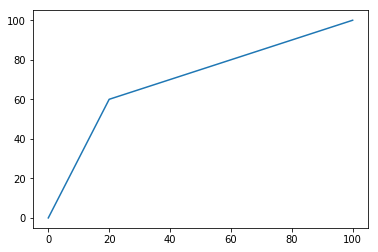

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(x,y)

In [84]:
tmp = "61.945674,230.5411 2.86184,6.95386 8.845689,7.98406 7.284685,4.89346 13.268532,6.43876 9.36602,1.5453 9.36603,5.92366 6.24401,8.24161 7.80502,7.21141 12.48803,5.15101 7.28469,9.27181 10.14652,7.72651 10.66686,7.72651 4.16268,2.5755 9.62619,1.80286 7.80502,-3.86326 16.39054,-5.92366 8.32535,0.77265 16.91088,-5.151 6.50418,-5.15101 12.48804,-7.21141 9.62618,-5.40856 7.28469,-2.0604 8.84569,-9.27181 8.06518,-5.66611 14.30921,-9.27181 11.70753,-9.27181 8.58552,-1.54531 8.84569,-8.49916 8.06518,-4.89345"
x = list()
y = list()
trans = (0,0)
viewBox = (0, 0, 668, 340)

width = 668
height = 340

for i,t in enumerate(tmp.split(' ')):
    p = t.split(',')
    x.append(((float(p[0]) + trans[0])/viewBox[2]) * width)
    y.append(((float(p[1]) + trans[1])/viewBox[3]) * height)

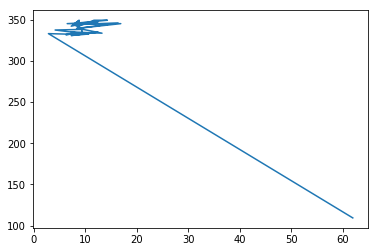

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(x,y)

In [73]:
print(x)
print(y)

[  0.          20.00000113 100.00000378]
[-3.02362221e-05  6.00000106e+01  1.00000000e+02]


In [1]:
from oggm import cfg

In [6]:
cfg.initialize()

2019-01-08 16:32:26: oggm.cfg: Parameter file: /Users/oberrauch/oggm/oggm/params.cfg


In [12]:
cfg.PARAMS['glen_a']

2.4e-24

In [1]:
import matplotlib.pyplot as plt

In [63]:
def plot_colors(title, names, colors):
    nrows = len(colors)
    
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.5, right=0.99)
    axes[0].set_title(title, fontsize=14)

    for ax, name, color in zip(axes, names, colors):
        # create 'colormap' with one color
        cmap = mcolors.LinearSegmentedColormap.from_list(
            name, [color, color])
        ax.imshow([[1]], aspect='auto', cmap=cmap)
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=12)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

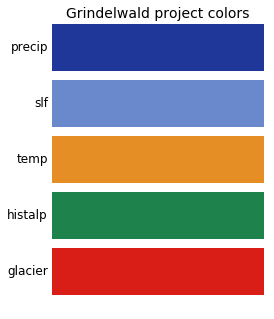

In [64]:
plot_colors('Grindelwald project colors', mycolors.colors, colors)

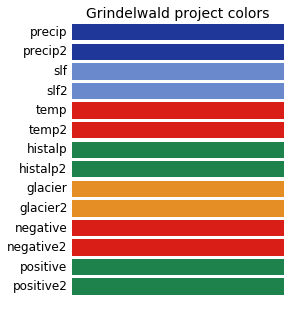

In [10]:
import sys
sys.path.append('../code/')
import mycolors
%matplotlib inline
mycolors.view()

[0.1, 0.2, 0.5, 1.0]

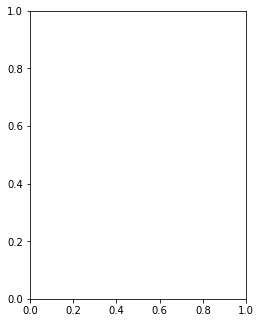

In [14]:
import matplotlib.pyplot as plt
f = plt.figure()
ax = f.add_axes([0.1,0.2,0.5,1])
list(ax.get_position().bounds)

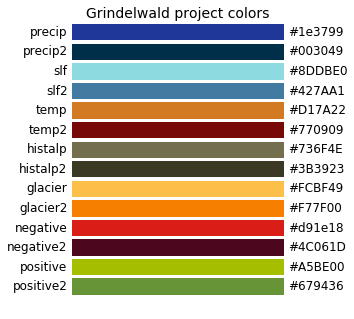

In [31]:
# reload my color module
import mycolors
import importlib
importlib.reload(mycolors)
mycolors.view(hex=True)

In [25]:
plot_colors('', colors)

NameError: name 'plot_colors' is not defined

In [35]:
colors = [eval('mycolors.{}'.format(c)) for c in mycolors.colors]

In [2]:
def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

In [9]:
import matplotlib.colors as mcolors

In [22]:
some = mcolors.LinearSegmentedColormap.from_list('some', ['r'])

In [42]:
plt.imshow([[1]], cmap=some)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10d293840> (for post_execute):


ValueError: data mapping points must start with x=0 and end with x=1

ValueError: data mapping points must start with x=0 and end with x=1

<Figure size 432x288 with 1 Axes>

In [9]:
# imports
import os
import pandas as pd
%matplotlib inline

In [62]:
# get/list all file in directory
directory = '/Users/oberrauch/work/grindelwald/raw_data/station_data'
files = os.listdir(directory)
files

['monthly_precip_slf.csv',
 'yearly_precip_slf.csv',
 'monthly_precip_stations.csv',
 'monthly_temp_stations.csv',
 'slf_stations.csv',
 'monthly_precip_eiger_scheidegg.csv',
 'monthly_temp_jungfrau.csv',
 'readme.txt']

In [73]:
file = 'slf_stations.csv'

In [74]:
# read single file
pd.read_csv(os.path.join(directory, file), index_col=0)

,Name,Parameter,Data source,Longitude/Latitude,Coordinates [km],Elevation [m]
SLFFIR,Grindelwald / First,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°04'/46°40',647900/168780,2110
SLFGAD,Gadmen / Gschletteregg,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°24'/46°45',673270/177465,2060
SLFGO3,Goms / Treichbode,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°14'/46°29',660650/148950,2430
SLFGU2,Guttannen / Homad,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°17'/46°41',665100/170100,2110
SLFSH2,Schilthorn / Türliboden,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,7°50'/46°35',630380/158450,2360
SLFUR2,Urseren / Giltnasen,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°31'/46°35',682400/160100,2170


In [63]:
i = 5

In [64]:
# select single file
file = files[i]
print(file)

monthly_precip_eiger_scheidegg.csv


In [68]:
# read single file
pd.read_csv(os.path.join(directory, file), index_col=0)

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
1998-10,NaN,NaN,NaN,NaN,NaN,136.0
1998-11,NaN,NaN,NaN,NaN,NaN,7.6
1998-12,NaN,NaN,NaN,NaN,NaN,1.4
1999-01,NaN,NaN,NaN,NaN,NaN,28.8
1999-02,NaN,NaN,NaN,NaN,NaN,3.4
1999-03,NaN,NaN,NaN,NaN,NaN,21.2
1999-04,NaN,NaN,NaN,NaN,NaN,22.0
1999-05,NaN,NaN,NaN,NaN,NaN,162.4
1999-06,NaN,NaN,NaN,NaN,NaN,214.8
1999-07,NaN,NaN,NaN,NaN,NaN,115.8


In [53]:
i += 1
print(i)

4


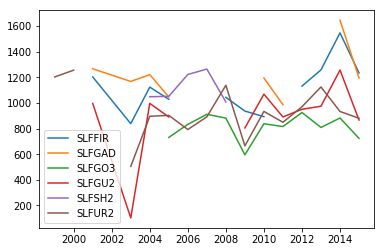

In [8]:


path = '../raw_data/yearly_precip_slf_stations.csv'
pd.read_csv(path, index_col=0).plot()

## Resample sum with NaN filter

In [8]:
# get data
data = pd.read_csv('tmp.csv', index_col=0, parse_dates=True)

In [9]:
resample_sum(data, 'M')

In [12]:
data.resample('M').sum(min_count=25)

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
time,,,,,,
1998-10-31,NaN,NaN,NaN,NaN,NaN,136.0
1998-11-30,NaN,NaN,NaN,NaN,NaN,7.6
1998-12-31,NaN,NaN,NaN,NaN,NaN,1.4
1999-01-31,NaN,NaN,NaN,NaN,NaN,28.8
1999-02-28,NaN,NaN,NaN,NaN,NaN,3.4
1999-03-31,NaN,NaN,NaN,NaN,NaN,21.2
1999-04-30,NaN,NaN,NaN,NaN,NaN,22.0
1999-05-31,NaN,NaN,NaN,NaN,NaN,162.4
1999-06-30,NaN,NaN,NaN,NaN,NaN,214.8


In [1]:
def resample_sum(data, rule, ):
    # count number of data points in new intervall 
    count = data.resample(rule).count()
    # set NaN counts to zero
    count[pd.isna(count)] = 0
    # sum up data
    data = data.resample(rule).sum()
    # 

### Get usefull data
First all `NaN` counts will be set to 99 (arbitrary high number). The second step is to set all monthly sums with more than 7 missing days to `NaN`.

In [ ]:
# get rid of MultiIndex again...
monthly_data.columns = monthly_data.columns.droplevel(1)
missing_days.columns = missing_days.columns.droplevel(1)

In [202]:
# set number of missing records of month without any data records
# to an arbitrary high number (> 31)
missing_days[pd.isna(missing_days)] = 99
missing_days.head()

,SLFFIR,SLFGAD,SLFGO3,SLFGU2,SLFSH2,SLFUR2
time,,,,,,
1998-10-31,99.0,99.0,99.0,99.0,99.0,0.0
1998-11-30,99.0,99.0,99.0,99.0,99.0,0.0
1998-12-31,99.0,99.0,99.0,99.0,99.0,0.0
1999-01-31,99.0,99.0,99.0,99.0,99.0,0.0
1999-02-28,99.0,99.0,99.0,99.0,99.0,0.0


In [203]:
# define threshhold of max number of days with missing records
threshhold = 7
# set precip sum of month with too much missing records to NaN
monthly_data[missing_days > threshhold] = np.nan

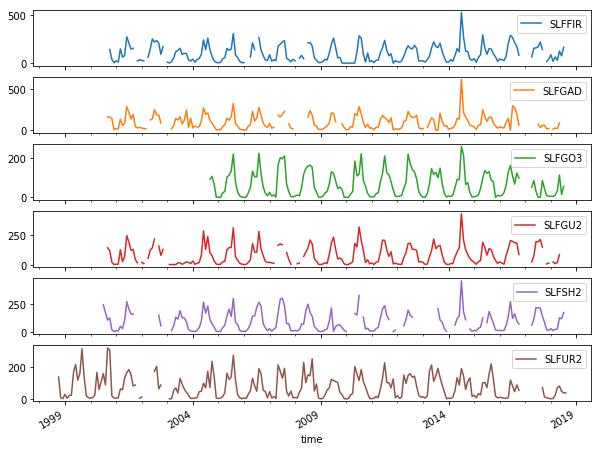

In [206]:
monthly_data.plot(subplots=True, figsize=[10,8]);

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


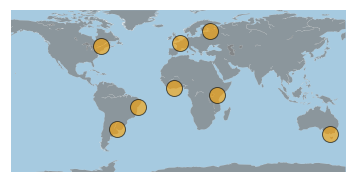

In [3]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
# Make a data frame with the GPS of a few cities:
data = pd.DataFrame({
'lat':[-58, 2, 145, 30.32, -4.03, -73.57, 36.82, -38.5],
'lon':[-34, 49, -38, 59.93, 5.33, 45.52, -1.29, -12.97],
'name':['Buenos Aires', 'Paris', 'melbourne', 'St Petersbourg', 'Abidjan', 'Montreal', 'Nairobi', 'Salvador']
})
 
# A basic map
m=Basemap(llcrnrlon=-160, llcrnrlat=-75,urcrnrlon=160,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")
 
# Add a marker per city of the data frame!
m.plot(data['lat'], data['lon'], linestyle='none', 
       marker="o", markersize=16, alpha=0.6, c="orange",
       markeredgecolor="black", markeredgewidth=1)

## Define coordinate rectangle around the Upper Grindelwald Glacier

In [1]:
import numpy as np

from oggm import utils

import sys
sys.path.append('../code/')
import utils as mutils
import idaweb

In [2]:
# get RGI entry for Upper Grindelwald Glacier
rgi_id = '11.01270'
rgi_df = mutils.rgi_finder([rgi_id])
rgi_df

,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
RGIId,,,,,,,,,,,,,,,,,,,,,
RGI60-11.01270,G008119E46614N,20030799,20030999,8.11933,46.6143,11,1,9.023,1361,3682,...,281,6412,0,0,0,0,9,9,None,"POLYGON ((8.127299661000052 46.63327544100008,..."


In [3]:
# get center coordinates
c_lon = rgi_df.CenLon.values[-1]
c_lat = rgi_df.CenLat.values[-1]

# specify window size in km
width = 60
height = 40

# compute window vertices
limits = idaweb.get_wgs_limits(c_lon, c_lat, width, height)
# show values
for l in limits:
    print(l)


7°44'..8°31'
46°26'..46°48'


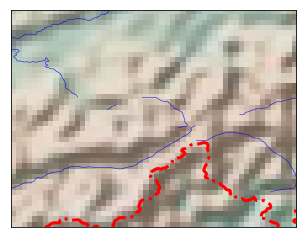

In [7]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# get limits as numbers
lon_limits, lat_limits = idaweb.get_wgs_limits(c_lon, c_lat, width, height, out='dec')

# A basic map
border = 0.5
m = Basemap(llcrnrlon=lon_limits[0]-border,
            llcrnrlat=lat_limits[0]-border, 
            urcrnrlon=lon_limits[1]+border, 
            urcrnrlat=lat_limits[1]+border,
            resolution='h')
m.drawcountries(color='r', linestyle='-.', linewidth=3)
m.drawrivers(color='b')
m.shadedrelief()

## Read combined IDAWEB data

In [277]:
import pandas as pd
import os
%matplotlib inline

In [316]:
# specfify path to order directory
order_path = '../raw_data/order61372'

In [317]:
# get list of all files
all_file = os.listdir(order_path)
# get legend file
legend_filename = [f for f in all_file  if 'legend' in f][-1]
# get data file
data_filename = [f for f in all_file  if 'data' in f][-1]

In [318]:
# read stations from legend file
colspecs = [(0,10), (10,47), (47, 64), (64, 115), (115, 140), (140, 157), (157, 200)]
stations = pd.read_fwf(os.path.join(order_path, legend_filename),
                       colspecs=colspecs, encoding='latin-1',
                       skiprows=31, skipfooter=7)
# correct index
stations.index = stations.stn
stations.drop(columns='stn', inplace=True)

stations

,Name,Parameter,Datenquelle,Länge/Breite,Koordinaten [km],Höhe ü. M. [m]
stn,,,,,,
SLFGAD,Gadmen / Gschletteregg,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°24'/46°45',673270/177465,2060
SLFGO3,Goms / Treichbode,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°14'/46°29',660650/148950,2430
SLFFIR,Grindelwald / First,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°04'/46°40',647900/168780,2110
SLFGU2,Guttannen / Homad,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,8°17'/46°41',665100/170100,2110
KSE,Kleine Scheidegg,rre150d0,MeteoSchweiz,7°58'/46°35',639896/159346,2060
BEKSE,Kleine Scheidegg,rre150d0,Kanton Bern,7°58'/46°35',639896/159346,2060
SLFMAE,Männlichen,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,7°57'/46°37',638650/163175,2165
URRET,Realp / Tiefenbach,rre150d0,Kanton Uri,8°28'/46°36',678390/160750,2119
SLFSH2,Schilthorn / Türliboden,rre150d0,Eidg. Institut für Schnee- und Lawinenforschung,7°50'/46°35',630380/158450,2360


In [327]:
precip_data = pd.read_csv(os.path.join(order_path, data_filename), encoding='latin-1', skiprows=2, delimiter=';')

In [343]:
# get lines where header is repeated
index_to_del = precip_data.loc[precip_data.stn == 'stn'].index.values
# delete those lines
precip_data.drop(index=index_to_del, inplace=True)

In [345]:
precip_data.head()

,stn,time,rre150d0
0,SLFGAD,20000816,0.0
1,SLFGAD,20000817,4.4
2,SLFGAD,20000818,0.0
3,SLFGAD,20000819,0.0
4,SLFGAD,20000820,1.2


## Test IDAWEB module

In [15]:
import numpy as np
import pandas as pd

from oggm import utils

import sys
import os
sys.path.append('../code/')
import utils as mutils
import idaweb

In [20]:
# specfify path to order directory
order_path = '../raw_data/order61302'
index_file, legend_files, data_files = idaweb.list_files(order_path)

In [45]:
# read index file
index = idaweb.read_index_file(os.path.join(order_path, index_file))
# get files with montly prcipitation sum
montly_filenames = index.loc[index.Parameter.str.contains('Monat'), 'Dateiname']
index.loc[index.Parameter.str.contains('Monat')]

,Dateiname,Dateityp,Station,Parameter,Zeitinterval
0,order_61302_EIG_rre150m0_1_data.txt,Daten,Eigergletscher,Niederschlag; Monatssumme,190810-195204
34,order_61302_BEKSE_rre150m0_1_data.txt,Daten,Kleine Scheidegg,Niederschlag; Monatssumme,200808-201807
36,order_61302_KSE_rre150m0_1_data.txt,Daten,Kleine Scheidegg,Niederschlag; Monatssumme,195504-201807


In [46]:
# drop the BEKSE data since it overlaps with the KSE data anyway
montly_filenames = montly_filenames.drop(34).values

In [49]:
# define data parser for year month date format
montly_parser = lambda x: pd.datetime.strptime(x, '%Y%m')

In [50]:
# create empty list as container
data_df = list()

# read all data files
for data_file in montly_filenames:
    data_file = os.path.join(order_path, data_file)
    data = idaweb.read_data_file(data_file, date_parser=montly_parser)
    data_df.append(data)
    
# convert into DataFrame
data_df = pd.concat(data_df, axis=1)

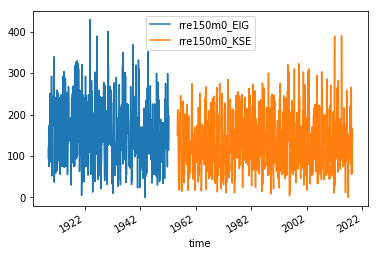

In [53]:
# view data
data_df.plot()

In [ ]:
# save this data to file
path = '../raw_data/idaweb_precip.csv'
data_df.to_csv(path)

## Read single IDAWEB data

In [346]:
import pandas as pd
import os
%matplotlib inline

In [351]:
# specfify path to order directory
order_path = '../raw_data/order61373'

In [352]:
# get list of all files
all_file = os.listdir(order_path)
# get index file
index_filename = [f for f in all_file  if 'index' in f][-1]
index_filename

'order_61373_index.txt'

In [353]:
# read index file
colspecs = [(0,40), (40,50), (50,87), (87,147), (147,200)]
index = pd.read_fwf(os.path.join(order_path, index_filename), colspecs=colspecs, skiprows=7, encoding='latin-1')
index.loc[index.Dateityp == 'Daten']

,Dateiname,Dateityp,Station,Parameter,Zeitinterval
0,order_61373_SLFGAD_rre150d0_1_data.txt,Daten,Gadmen / Gschletteregg,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20000815-20161218
2,order_61373_SLFGAD_rre150d0_2_data.txt,Daten,Gadmen / Gschletteregg,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170221-20180818
4,order_61373_SLFGO3_rre150d0_1_data.txt,Daten,Goms / Treichbode,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20040824-20161106
6,order_61373_SLFGO3_rre150d0_2_data.txt,Daten,Goms / Treichbode,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170212-20180818
8,order_61373_SLFFIR_rre150d0_1_data.txt,Daten,Grindelwald / First,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20000919-20161106
10,order_61373_SLFFIR_rre150d0_2_data.txt,Daten,Grindelwald / First,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170208-20180817
12,order_61373_SLFGU2_rre150d0_1_data.txt,Daten,Guttannen / Homad,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20000815-20161106
14,order_61373_SLFGU2_rre150d0_2_data.txt,Daten,Guttannen / Homad,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170219-20180818
16,order_61373_KSE_rre150d0_1_data.txt,Daten,Kleine Scheidegg,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,19601231-20180730
18,order_61373_BEKSE_rre150d0_1_data.txt,Daten,Kleine Scheidegg,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20080831-20180818


### Daily precipitation sum (6 UTC - 6 UTC next day)

In [356]:
# create empty container for monthly precipitation data
daily = dict()
# define data parser for year month date format
date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%d')

# read monthly precipitation sum
for data_file in index.loc[(index.Dateityp == 'Daten') & (index.Parameter.str.contains('Tages')), 'Dateiname']:
    # get path to current file
    data_file = os.path.join(order_path, data_file)
    # read file *.txt: values seperated by semicolon ';', encoding = Latin 1
    precip_df = pd.read_csv(data_file, sep=';', encoding='latin-1', index_col=1,
                            parse_dates=[1], date_parser=date_parser, na_values='-')
    # get station label
    station = precip_df.stn.values[-1]
    # remove column containing station label
    precip_df.drop(columns='stn', inplace=True)

    # add to dictionary
    if station in daily.keys():
        # some stations have multiple file for different time periods,
        # which are concatened here if necessary
        precip_df = pd.concat([daily[station], precip_df])
        daily[station] = precip_df
    else:
        daily[station] = precip_df

# create DataFrame with MultiIndex columns
daily_df = pd.concat(daily, axis=1, keys=daily.keys())
# keep only station name if all show the same parameter
if daily_df.columns.levels[1].size == 1:
    print(daily_df.columns.levels[1])
    daily_df.columns = daily_df.columns.droplevel(1)

Index(['rre150d0'], dtype='object')


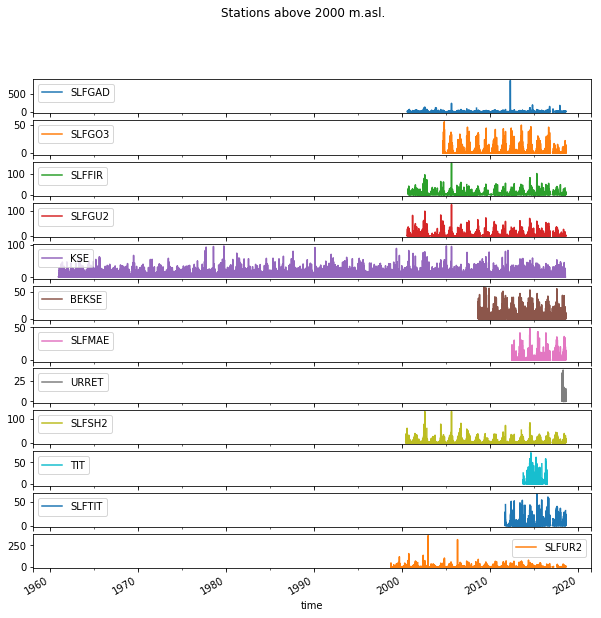

In [357]:
# first look
daily_df.plot(subplots=True, legend=True, figsize=[10,10], title='Stations above 2000 m.asl.')

## Read IDAWEB data

In [41]:
import pandas as pd
import os
%matplotlib inline

In [42]:
# specfify path to order directory
order_path = '/Users/oberrauch/Downloads/order61302'

In [43]:
# get list of all files
all_file = os.listdir(order_path)
# get index file
index_filename = [f for f in all_file  if 'index' in f][-1]
index_filename

'order_61302_index.txt'

In [44]:
# read index file
colspecs = [(0,40), (40,50), (50,87), (87,147), (147,200)]
index = pd.read_fwf(os.path.join(order_path, index_filename), colspecs=colspecs, skiprows=7, encoding='latin-1')
index.loc[index.Dateityp == 'Daten']

,Dateiname,Dateityp,Station,Parameter,Zeitinterval
0,order_61302_EIG_rre150m0_1_data.txt,Daten,Eigergletscher,Niederschlag; Monatssumme,190810-195204
2,order_61302_SLFES2_rre150d0_1_data.txt,Daten,Frutigen / Elsige,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20001109-20161106
4,order_61302_SLFES2_rre150d0_2_data.txt,Daten,Frutigen / Elsige,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170208-20180810
6,order_61302_SLFOTT_rre150d0_1_data.txt,Daten,Frutigen / Ottere,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20000609-20161106
8,order_61302_SLFOTT_rre150d0_2_data.txt,Daten,Frutigen / Ottere,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170130-20180814
10,order_61302_SLFGAD_rre150d0_1_data.txt,Daten,Gadmen / Gschletteregg,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20000815-20161218
12,order_61302_SLFGAD_rre150d0_2_data.txt,Daten,Gadmen / Gschletteregg,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170221-20180814
14,order_61302_SLFFIR_rre150d0_1_data.txt,Daten,Grindelwald / First,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20000919-20161106
16,order_61302_SLFFIR_rre150d0_2_data.txt,Daten,Grindelwald / First,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20170208-20180814
18,order_61302_SLFOBM_rre150d0_1_data.txt,Daten,Gstaad / Ober Meiel,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,20001115-20161106


### Daily precipitation sum (6 UTC - 6 UTC next day)

In [358]:
# create empty container for monthly precipitation data
daily = dict()
# define data parser for year month date format
date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%d')

# read monthly precipitation sum
for data_file in index.loc[(index.Dateityp == 'Daten') & (index.Parameter.str.contains('Tages')), 'Dateiname']:
    # get path to current file
    data_file = os.path.join(order_path, data_file)
    # read file *.txt: values seperated by semicolon ';', encoding = Latin 1
    precip_df = pd.read_csv(data_file, sep=';', encoding='latin-1', index_col=1,
                            parse_dates=[1], date_parser=date_parser, na_values='-')
    # get station label
    station = precip_df.stn.values[-1]
    # remove column containing station label
    precip_df.drop(columns='stn', inplace=True)

    # add to dictionary
    if station in daily.keys():
        station = station + '_' + str(list(daily.keys()).count(station))
        daily[station] = precip_df
    else:
        daily[station] = precip_df

# create DataFrame with MultiIndex columns
daily_df = pd.concat(daily, axis=1, keys=daily.keys())
# keep only station name if all show the same parameter
if daily_df.columns.levels[1].size == 1:
    print(daily_df.columns.levels[1])
    daily_df.columns = daily_df.columns.droplevel(1)

Index(['rre150d0'], dtype='object')


In [187]:
# create empty container for monthly precipitation data
daily = dict()
# define data parser for year month date format
date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%d')

# read monthly precipitation sum
for data_file in index.loc[(index.Dateityp == 'Daten') & (index.Parameter.str.contains('Tages')), 'Dateiname']:
    # get path to current file
    data_file = os.path.join(order_path, data_file)
    # read file *.txt: values seperated by semicolon ';', encoding = Latin 1
    precip_df = pd.read_csv(data_file, sep=';', encoding='latin-1', index_col=1,
                            parse_dates=[1], date_parser=date_parser, na_values='-')
    # get station label
    station = precip_df.stn.values[-1]
    # remove column containing station label
    precip_df.drop(columns='stn', inplace=True)

    # add to dictionary
    if station in daily.keys():
        # some stations have multiple file for different time periods,
        # which are concatened here if necessary
        precip_df = pd.concat([daily[station], precip_df])
        daily[station] = precip_df
    else:
        daily[station] = precip_df

# create DataFrame with MultiIndex columns
daily_df = pd.concat(daily, axis=1, keys=daily.keys())
# keep only station name if all show the same parameter
if daily_df.columns.levels[1].size == 1:
    print(daily_df.columns.levels[1])
    daily_df.columns = daily_df.columns.droplevel(1)

Index(['rre150d0'], dtype='object')


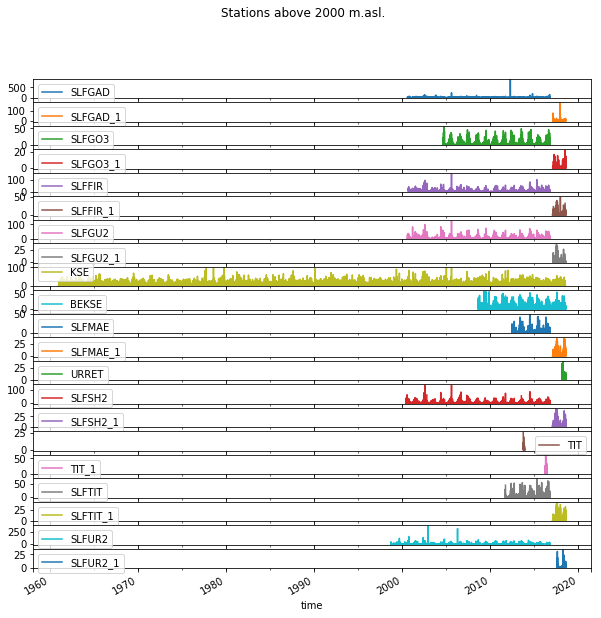

In [359]:
# first look
handles = daily_df.plot(subplots=True, legend=True, figsize=[10,10], title='Stations above 2000 m.asl.')

# add costum legend
lines = [h.lines[-1] for h in handles]
labels = [l.get_label() for l in lines]
#fig.legend(lines, labels, loc=9, bbox_to_anchor=(, -), ncol=5)

### Monthly Data

In [45]:
# create empty container for monthly precipitation data
monthly = dict()
# define data parser for year month date format
date_parser = lambda x: pd.datetime.strptime(x, '%Y%m')

# read monthly precipitation sum
for data_file in index.loc[(index.Dateityp == 'Daten') & (index.Parameter.str.contains('Monat')), 'Dateiname']:
    # get path to current file
    data_file = os.path.join(order_path, data_file)
    # read file *.txt: values seperated by semicolon ';', encoding = Latin 1
    precip_df = pd.read_csv(data_file, sep=';', encoding='latin-1', index_col=1,
                            parse_dates=[1], date_parser=date_parser)
    # get station label
    station = precip_df.stn.values[-1]
    # remove column containing station label
    precip_df.drop(columns='stn', inplace=True)
    # add to dictionary
    monthly[station] = precip_df
    
# create DataFrame with MultiIndex columns
monthly_df = pd.concat(monthly, axis=1, keys=monthly.keys())
# keep only station name if all show the same parameter
if monthly_df.columns.levels[1].size == 1:
    print(monthly_df.columns.levels[1])
    monthly_df.columns = monthly_df.columns.droplevel(1)

Index(['rre150m0'], dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20f0aac8>,
      dtype=object)

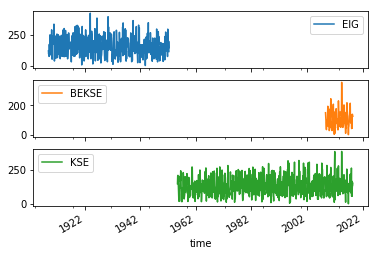

In [46]:
# first look
monthly_df.plot(subplots=True)

In [48]:
# extract data of interest
eig = monthly_df.EIG.dropna()
kse = monthly_df.KSE.dropna()


## Use `ulmo` to read NCDC GSOD data for Jungfraujoch

In [49]:
# import section
import ulmo
import pandas as pd
%matplotlib inline

In [9]:
# get stations list for Switzerland
st = pd.DataFrame(ulmo.ncdc.gsod.get_stations(country='SZ')).T
st.head()

,USAF,WBAN,begin,country,elevation,end,icao,latitude,longitude,name,state
020510-99999,020510,99999,1957-01-01,SZ,327.1,1959-12-31,,68.45,22.5,KARESUANDO,
020560-99999,020560,99999,1957-01-01,SZ,330.1,1959-12-31,,65.067,17.167,STENSELE,
020970-99999,020970,99999,1957-01-01,SZ,14.9,1974-07-02,,55.6,13.067,MALMO /BULLTOFTON,
066000-99999,066000,99999,1955-01-01,SZ,493,1967-09-30,,47.567,7.683,ST. CHRISCHONA,
066010-99999,066010,99999,1990-11-01,SZ,317,2018-08-07,,47.55,7.583,BASEL-BINNINGEN,


In [22]:
# find stations of interest
st = st.loc[st.name.str.contains('JUNGFRAU|INTERL|LAUTER')]
st

,USAF,WBAN,begin,country,elevation,end,icao,latitude,longitude,name,state
067300-99999,067300,99999,1935-01-01,SZ,3576,2018-08-07,,46.55,7.983,JUNGFRAUJOCH,
067340-99999,067340,99999,1977-06-16,SZ,578.6,2018-08-07,,46.667,7.867,INTERLAKEN,


In [41]:
# get the NCDN GSOD index station index for Jungfrau Joch
jungfrau_id = st.loc[st.name.str.contains('JUNGFRAU')].index.values[-1]

In [43]:
# get data from the jungfrau station
jungfrau_dict = ulmo.ncdc.gsod.get_data(jungfrau_id)

In [78]:
# convert into DataFrame
jungfrau_df = pd.DataFrame(jungfrau_dict[jungfrau_id])
# set date as index
jungfrau_df.index = jungfrau_df.date
jungfrau_df.drop(columns=['date'], inplace=True)
jungfrau_df.head()

,FRSHTT,USAF,WBAN,dew_point,dew_point_count,max_gust,max_temp,max_temp_flag,max_wind_speed,mean_temp,...,min_temp_flag,precip,precip_flag,sea_level_pressure,sea_level_pressure_count,snow_depth,station_pressure,station_pressure_count,visibility,visibility_count
date,,,,,,,,,,,,,,,,,,,,,
1973-01-02,000000,067300,99999,13.6,5,999.9,15.8,*,24.9,13.6,...,*,0.00,I,9999.9,0,999.9,656.8,4,43.5,5
1973-01-06,000000,067300,99999,-8.5,4,999.9,15.8,*,26.0,14.0,...,*,0.00,I,9999.9,0,999.9,659.5,4,43.5,4
1973-01-22,001000,067300,99999,5.4,5,999.9,8.6,*,9.9,5.4,...,*,99.99,,9999.9,0,999.9,646.9,5,5.9,5
1973-01-23,100000,067300,99999,-13.5,4,999.9,6.8,*,35.0,4.1,...,*,0.00,I,9999.9,0,999.9,654.8,4,32.6,4
1973-01-26,000000,067300,99999,-21.6,4,999.9,14.0,*,15.0,12.6,...,*,0.00,I,9999.9,0,999.9,653.5,4,43.5,4


In [80]:
# save DataFrame to raw_data folder, allowing future access
# without downloading the data (since it takes ages)
# @TODO: implement check for existing file before redowloading
jungfrau_path = '../raw_data/jungfrau_ncdc_gsod.csv'
jungfrau_df.to_csv(jungfrau_path)

# read saved file to assess integrity
jungfrau_tmp = pd.read_csv(jungfrau_path, index_col=0, parse_dates=True)
jungfrau_tmp.head()

,FRSHTT,USAF,WBAN,dew_point,dew_point_count,max_gust,max_temp,max_temp_flag,max_wind_speed,mean_temp,...,min_temp_flag,precip,precip_flag,sea_level_pressure,sea_level_pressure_count,snow_depth,station_pressure,station_pressure_count,visibility,visibility_count
date,,,,,,,,,,,,,,,,,,,,,
1973-01-02,0,67300,99999,13.6,5,999.9,15.8,*,24.9,13.6,...,*,0.00,I,9999.9,0,999.9,656.8,4,43.5,5
1973-01-06,0,67300,99999,-8.5,4,999.9,15.8,*,26.0,14.0,...,*,0.00,I,9999.9,0,999.9,659.5,4,43.5,4
1973-01-22,1000,67300,99999,5.4,5,999.9,8.6,*,9.9,5.4,...,*,99.99,,9999.9,0,999.9,646.9,5,5.9,5
1973-01-23,100000,67300,99999,-13.5,4,999.9,6.8,*,35.0,4.1,...,*,0.00,I,9999.9,0,999.9,654.8,4,32.6,4
1973-01-26,0,67300,99999,-21.6,4,999.9,14.0,*,15.0,12.6,...,*,0.00,I,9999.9,0,999.9,653.5,4,43.5,4


In [82]:
# subset precipitation data
jungfrau_precip = jungfrau_df.loc[:, jungfrau_df.columns.str.contains('precip')]
jungfrau_precip.head()

,precip,precip_flag
date,,
1973-01-02,0.00,I
1973-01-06,0.00,I
1973-01-22,99.99,
1973-01-23,0.00,I
1973-01-26,0.00,I


In [105]:
# examine precipiation data, grouped by flag
jungfrau_precip.groupby(['precip_flag', 'precip']).size()

precip_flag  precip
             99.99     8350
A            0.00         2
             0.35         1
             1.02         1
G            0.00         3
             0.04         1
             0.07         1
             0.08         1
H            0.00         1
I            0.00      7871
dtype: int64

The following flag show up:
- **A**: one report of 6-hour precipitation amount.
- **G**: one report of 24-hour precipitation amount.
- **H**: Station reported `0` as the amount for the day (eg, from 6-hour reports), but also reported at least one occurrence of precipitation in hourly observations--this could indicate a trace occurred, but should be considered as incomplete data for the day.
- **I**: Station did not report any precip data for the day and did not report any occurrences of precipitation in its hourly observations--it's still possible that precip occurred but was not reported.

Additionally, precipation amount of `99.99` signals missing data. Many stations do not report `0` on
days with no precipitation--therefore, `99.99` will often appear on these days.

We observe:
- On 8350 days precipitation data is missing (or was not reported).
- On 7871 days there was no precipitation reported.
- Precipitation (or it's absence) was reported on **only 11 days**.

**Conclusion:** The NCDC GSOD precipation data for the Jungfrau Joch is useless...

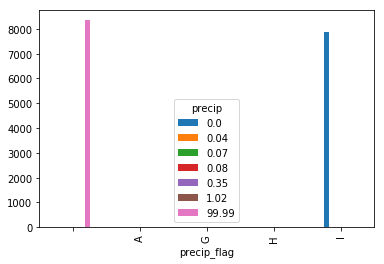

In [104]:
# visualize
jungfrau_precip.groupby(['precip_flag', 'precip']).size().unstack().plot(kind='bar')

## Read and visualize NCDN GSOD for Junfraujoch

In [33]:
pwd

'/Users/oberrauch/work/grindelwald/notebooks'

In [48]:
[h.strip() for h in data.columns]

['STN---',
 'WBAN',
 'YEARMODA',
 'TEMP',
 'Unnamed: 4',
 'DEWP',
 'Unnamed: 6',
 'SLP',
 'Unnamed: 8',
 'STP',
 'Unnamed: 10',
 'VISIB',
 'Unnamed: 12',
 'WDSP',
 'Unnamed: 14',
 'MXSPD',
 'GUST',
 'MAX',
 'MIN',
 'PRCP',
 'SNDP',
 'FRSHTT',
 'Unnamed: 22']

In [61]:
def fahrenheit2celsius(f):
    ''''''
    return (f - 32) / 1.8

def celsius2fahrenheit(c):
    ''''''
    return c * 1.8 + 32

In [68]:
# import section
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# read data
path = '/Users/oberrauch/work/grindelwald/raw_data/jungfrau_ncdcgsod.txt'
data = pd.read_csv(path, parse_dates=[2], skipinitialspace=True, index_col=2)
# get rid of leading or trailing whitespaces in header
new_header = [h.strip() for h in data.columns]
data.columns = new_header
# convert temperature from Fahrenheit into Celsius
data['TEMPC'] = fahrenheit2celsius(data.TEMP)
# show structure of the DataFrame
data.head()


,STN---,WBAN,TEMP,Unnamed: 4,DEWP,Unnamed: 6,SLP,Unnamed: 8,STP,Unnamed: 10,...,Unnamed: 14,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,Unnamed: 22,TEMPC
YEARMODA,,,,,,,,,,,,,,,,,,,,,
1973-01-02,67300,99999,13.6,5,13.6,5,9999.9,0,656.8,4,...,5,24.9,999.9,15.8*,8.6*,0.00I,999.9,0,NaN,-10.222222
1973-01-06,67300,99999,14.0,4,-8.5,4,9999.9,0,659.5,4,...,4,26.0,999.9,15.8*,12.2*,0.00I,999.9,0,NaN,-10.000000
1973-01-22,67300,99999,5.4,5,5.4,5,9999.9,0,646.9,5,...,5,9.9,999.9,8.6*,3.2*,99.99,999.9,1000,NaN,-14.777778
1973-01-23,67300,99999,4.1,4,-13.5,4,9999.9,0,654.8,4,...,4,35.0,999.9,6.8*,1.4*,0.00I,999.9,100000,NaN,-15.500000
1973-01-26,67300,99999,12.6,4,-21.6,4,9999.9,0,653.5,4,...,4,15.0,999.9,14.0*,10.4*,0.00I,999.9,0,NaN,-10.777778


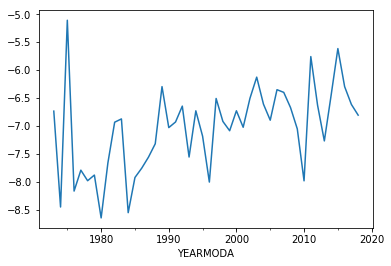

In [69]:
# plot average yearly temperature
data.TEMPC.resample('AS').mean().plot()

In [ ]:
# Station reported '0' as the amount
# for the day (eg, from 6-hour reports),
# but also reported at least one
# occurrence of precipitation in hourly
# observations--this could indicate a
# trace occurred, but should be considered

In [86]:
# deal with precipitation data
data['PRCPMM'] = data['PRCP'].copy()
# parse '0.00I' into 0 mm
# Station did not report any precip data
# for the day and did not report any
# occurrences of precipitation in its hourly
# observations--it's still possible that
# precip occurred but was not reported.
data.loc[data.PRCPMM == '0.00I', 'PRCPMM'] = 0
# parse '0.00H' into 0 mm
# Station reported '0' as the amount
# for the day (eg, from 6-hour reports),
# but also reported at least one
# occurrence of precipitation in hourly
# observations--this could indicate a
# trace occurred, but should be considered
data.loc[data.PRCPMM == '0.00H', 'PRCPMM'] = 0
# parse '99.99' to 0 mm
data.loc[data.PRCPMM == '99.99 ', 'PRCPMM'] = 0

# 
data.loc[data.PRCPMM != 0]

,STN---,WBAN,TEMP,Unnamed: 4,DEWP,Unnamed: 6,SLP,Unnamed: 8,STP,Unnamed: 10,...,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,Unnamed: 22,TEMPC,PRCPMM
YEARMODA,,,,,,,,,,,,,,,,,,,,,
1980-02-11,67300,99999,3.2,4,-7.6,4,9999.9,0,652.5,4,...,40.0,999.9,5.0*,1.4*,0.00H,999.9,101000,NaN,-16.000000,0.00H
1981-04-02,67300,99999,20.1,5,19.0,5,9999.9,0,653.5,4,...,39.8,999.9,21.2*,19.4*,0.00A,999.9,100000,NaN,-6.611111,0.00A
1981-07-21,67300,99999,27.0,5,26.6,5,9999.9,0,659.9,4,...,23.9,999.9,41.0,23.0*,1.02A,999.9,101000,NaN,-2.777778,1.02A
1983-06-24,67300,99999,30.4,8,28.9,8,9999.9,0,662.5,8,...,16.9,999.9,33.8,27.9,0.35A,999.9,100000,NaN,-0.888889,0.35A
1987-11-03,67300,99999,24.4,8,-19.0,7,9999.9,0,659.7,7,...,20.0,28.0,27.9*,15.8,0.00A,999.9,0,NaN,-4.222222,0.00A
2002-06-11,67300,99999,24.4,20,12.2,19,9999.9,0,659.2,20,...,20.0,34.0,30.0,18.0,0.08G,999.9,0,NaN,-4.222222,0.08G
2002-06-12,67300,99999,28.6,21,22.1,21,9999.9,0,663.7,21,...,18.1,34.0,31.6,24.6,0.00G,999.9,1000,NaN,-1.888889,0.00G
2002-07-11,67300,99999,30.3,22,24.1,22,9999.9,0,662.4,22,...,28.0,52.1,40.5,23.9,0.04G,999.9,0,NaN,-0.944444,0.04G
2002-07-12,67300,99999,33.2,24,30.5,24,9999.9,0,663.6,24,...,21.0,999.9,43.7,28.9,0.00G,999.9,11000,NaN,0.666667,0.00G


In [70]:
# plot total yearly precipitation
data.PRCP.resample('AS').sum().plot()


TypeError: Empty 'DataFrame': no numeric data to plot

## Find certain glaciers by RGI ID

In [ ]:
# import
from oggm.utils import get_rgi_glacier_entities

# specify RGI version
rgi_version = '60'
# specify RGI ID of glaciers of interest
rids = ['11.03232', '11.03209', '11.03241']
rids = ['11.01238', '11.01450']
rids = ['RGI{}-{}'.format(rgi_version, rid) for rid in rids]

# get said RGI entries
rgi_dir = get_rgi_glacier_entities(rids, version=rgi_version)
# set RGIId as index
rgi_dir.index = rgi_dir.RGIId

# visualize
print(rgi_dir[['CenLon', 'CenLat', 'Name']])